In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [115]:
marketing = pd.read_csv('Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases',
       'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases',
       'Days_Enrolled', 'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One',
       'Accept_Rate', 'Cust_Accept (%)'],
      dtype='object')

In [76]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 22 columns):
Age                    2227 non-null int64
Education              2227 non-null object
Relationship_Status    2227 non-null object
Income                 2227 non-null float64
Children               2227 non-null int64
Wine ($)               2227 non-null int64
Fruit ($)              2227 non-null int64
Meat ($)               2227 non-null int64
Fish ($)               2227 non-null int64
Sweets ($)             2227 non-null int64
Gold_Products ($)      2227 non-null int64
Total Spent ($)        2227 non-null int64
Discount_Purchases     2227 non-null int64
Web_Purchases          2227 non-null int64
Catalog_Purchases      2227 non-null int64
Store_Purchases        2227 non-null int64
Days_Enrolled          2227 non-null float64
Avg_Purch_Freq         2227 non-null float64
Avg_Spend ($)          2227 non-null float64
Accept_One             2227 non-null int64
Accept_Rate            

**Preprocessing for Customer Segmentation / Classification Below**

In [116]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

marketing_ml = marketing.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)

### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Appending the categorical features to end on unskewed DF ###
ml = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']])
ml.columns = ['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']

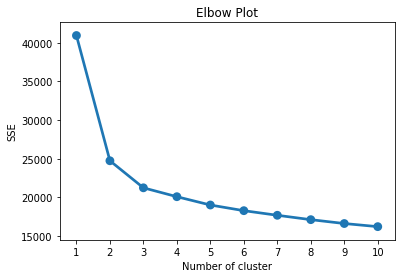

3 clusters looks optimal


In [117]:
from sklearn.cluster import KMeans
import seaborn as sns

X = ml
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('Elbow Plot')
plt.show()
print('3 clusters looks optimal')

In [182]:
customer_clusters = pd.DataFrame(marketing[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Total Spent ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One', 'Cust_Accept (%)']])
### Frequency ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Avg_Purch_Freq']])
customer_clusters['FrequencyCluster'] = kmeans.predict(ml[['Avg_Purch_Freq']])
freq = customer_clusters.groupby('FrequencyCluster')[['Avg_Purch_Freq']].mean().sort_values('Avg_Purch_Freq', ascending=True).reset_index(drop=False)
print(freq)
### Value of each visit ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Avg_Spend ($)']])
customer_clusters['SpendCluster'] = kmeans.labels_
print('\n')
spend = customer_clusters.groupby('SpendCluster')[['Avg_Spend ($)']].mean().sort_values('Avg_Spend ($)', ascending=False).reset_index(drop=False)
print(spend)
### Total Revenue ###
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml[['Total Spent ($)']])
customer_clusters['RevenueCluster'] = kmeans.labels_
print('\n')
revenue = customer_clusters.groupby('RevenueCluster')[['Total Spent ($)']].mean().sort_values('Total Spent ($)', ascending=False).reset_index(drop=False)
print(revenue)

   FrequencyCluster  Avg_Purch_Freq
0                 1       13.409083
1                 0       33.090943
2                 2       98.166899


   SpendCluster  Avg_Spend ($)
0             0      73.129444
1             2      26.727760
2             1       7.742417


   RevenueCluster  Total Spent ($)
0               0      1207.000000
1               2       300.107607
2               1        50.880109


In [183]:
### Reassigning Cluster Values Before Giving Overall Score to Customers ###
for idx, row in customer_clusters.iterrows():
    if row['FrequencyCluster'] == freq.loc[0, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 0
    elif row['FrequencyCluster'] == freq.loc[1, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 1
    elif row['FrequencyCluster'] == freq.loc[2, 'FrequencyCluster']:
        customer_clusters.loc[idx, 'FrequencyCluster'] = 2
    if row['SpendCluster'] == spend.loc[0, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 0
    elif row['SpendCluster'] == spend.loc[1, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 1
    elif row['SpendCluster'] == spend.loc[2, 'SpendCluster']:
        customer_clusters.loc[idx, 'SpendCluster'] = 2
    if row['RevenueCluster'] == revenue.loc[0, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 0
    elif row['RevenueCluster'] == revenue.loc[1, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 1
    elif row['RevenueCluster'] == revenue.loc[2, 'RevenueCluster']:
        customer_clusters.loc[idx, 'RevenueCluster'] = 2

### Calculating Each Customer's Overall Score ###
customer_clusters['Overall_Score'] = customer_clusters['FrequencyCluster'] + customer_clusters['SpendCluster'] + customer_clusters['RevenueCluster']
customer_clusters = customer_clusters.drop(['FrequencyCluster', 'SpendCluster', 'RevenueCluster'], axis=1)
print(customer_clusters.groupby('Overall_Score')['Avg_Purch_Freq', 'Avg_Spend ($)', 'Total Spent ($)', 'Accept_One', 'Cust_Accept (%)'].mean())

               Avg_Purch_Freq  Avg_Spend ($)  Total Spent ($)  Accept_One  Cust_Accept (%)
Overall_Score                                                                             
0                   13.432287      71.342715      1492.251064    0.540426        19.645390
1                   24.620896      59.827619      1226.647727    0.429924        12.058081
2                   23.878741      31.551715       645.463576    0.248344         6.456954
3                   36.661302      22.545232       324.602649    0.208609         4.415011
4                   55.608152      15.738413       154.287671    0.136986         2.739726
5                   45.586793       8.774794        63.399177    0.144033         3.155007
6                  101.669086       7.311886        45.309979    0.121019         2.476999


In [185]:
### Assigning Customer Value Groups ###
customer_clusters['Customer_Value'] = ''
for idx, row in customer_clusters.iterrows():
    if row['Overall_Score'] == 0 or row['Overall_Score'] == 1:
        customer_clusters.loc[idx, 'Customer_Value'] = 'High'
    if row['Overall_Score'] == 2 or row['Overall_Score'] == 3 or row['Overall_Score'] == 4:
        customer_clusters.loc[idx, 'Customer_Value'] = 'Medium'
    if row['Overall_Score'] == 5 or row['Overall_Score'] == 6:
        customer_clusters.loc[idx, 'Customer_Value'] = 'Low'
customer_clusters.drop('Overall_Score', axis=1)
print(customer_clusters['Customer_Value'].value_counts())

print(customer_clusters.groupby('Customer_Value')['Avg_Purch_Freq', 'Avg_Spend ($)', 'Total Spent ($)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False))


High      763
Medium    750
Low       714
Name: Customer_Value, dtype: int64
                Avg_Purch_Freq  Avg_Spend ($)  Total Spent ($)  Accept_One  Cust_Accept (%)
Customer_Value                                                                             
High                 21.174863      63.374208      1308.452163    0.463958        14.394932
Medium               35.202511      24.846782       420.648000    0.210667         4.911111
Low                  82.582255       7.809767        51.466387    0.128852         2.707750


In [186]:
pd.set_option('display.expand_frame_repr', False)

### Getting Purchase Channel Percentages and Product Percentages ###
customer_clusters['Total Purchases'] = customer_clusters['Discount_Purchases'] + customer_clusters['Web_Purchases'] + customer_clusters['Catalog_Purchases'] + customer_clusters['Store_Purchases']
for category in ['Discount_Purchases', 'Web_Purchases','Catalog_Purchases', 'Store_Purchases']:
    customer_clusters[category[:-10] + ' (%)'] = (customer_clusters[category] / customer_clusters['Total Purchases']) * 100
for category in ['Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)','Gold_Products ($)']:
    customer_clusters[category[:-3] + ' (%)'] = (customer_clusters[category] / customer_clusters['Total Spent ($)']) * 100


print(customer_clusters.groupby('Customer_Value')['Age', 'Income', 'Children', 'Days_Enrolled', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False))
print(customer_clusters.groupby('Customer_Value')['Wine  (%)', 'Fruit  (%)', 'Meat  (%)', 'Fish  (%)',
       'Sweets  (%)', 'Gold_Products  (%)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False))
print(customer_clusters.groupby('Customer_Value')['Discount (%)', 'Web (%)', 'Catalog (%)',
       'Store (%)', 'Accept_One', 'Cust_Accept (%)'].mean().sort_values('Cust_Accept (%)', ascending=False))

                      Age        Income  Children  Days_Enrolled  Accept_One  Cust_Accept (%)
Customer_Value                                                                               
High            46.744430  72342.730467  0.495413     436.187418    0.463958        14.394932
Medium          46.434667  50117.383063  1.088000     505.092000    0.210667         4.911111
Low             41.886555  31937.984284  1.295518     489.770308    0.128852         2.707750
                Wine  (%)  Fruit  (%)  Meat  (%)  Fish  (%)  Sweets  (%)  Gold_Products  (%)  Accept_One  Cust_Accept (%)
Customer_Value                                                                                                           
High            50.032547    4.315963  28.640354   6.202857     4.553133            6.255146    0.463958        14.394932
Medium          51.245582    4.576735  21.564262   6.178194     4.510005           11.925222    0.210667         4.911111
Low             35.847312    5.950542  24.

Text(0.5, 1, 'Average Spend Per Purchase vs. Total Spent')

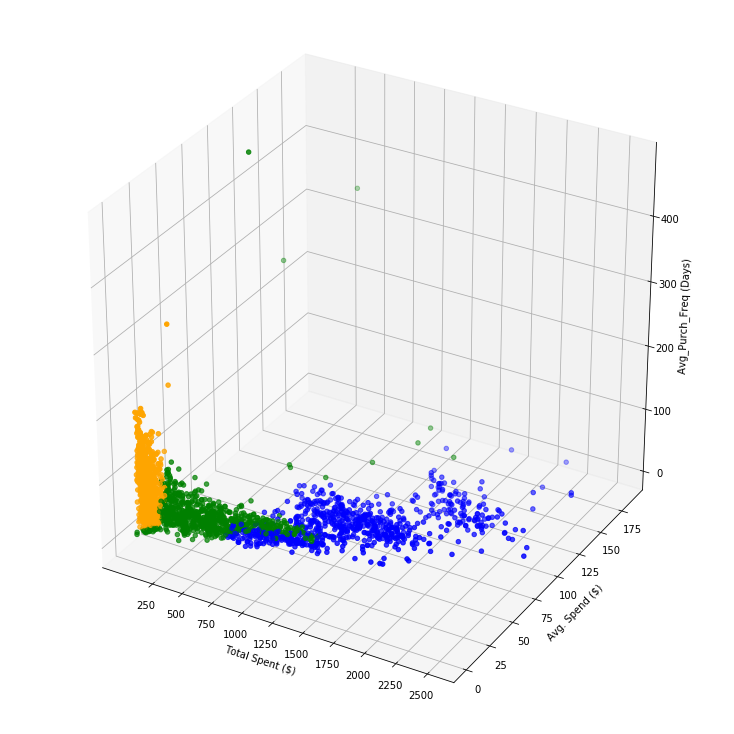

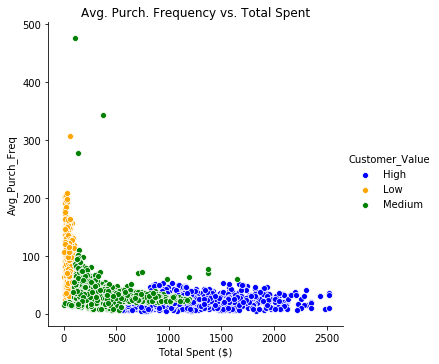

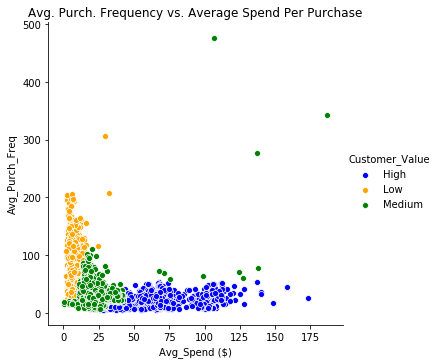

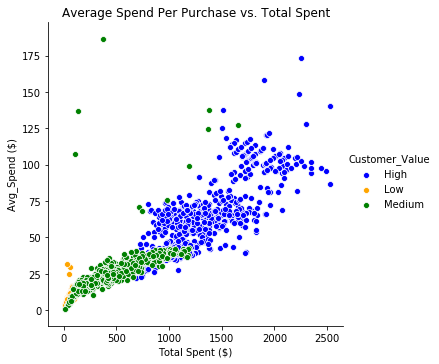

In [189]:
### Frequency vs Revenue ###
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

matplotlib.rcParams['figure.figsize'] = (10,10)

color = { 'High': 'blue', 'Medium': 'green', 'Low': 'orange'}

customer_clusters['colors'] = customer_clusters['Customer_Value'].replace({ 'High': 'blue', 'Medium': 'green', 'Low': 'orange'})

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_clusters['Total Spent ($)'], customer_clusters['Avg_Spend ($)'], customer_clusters['Avg_Purch_Freq'],
           c=customer_clusters['colors'])
ax.set_xlabel('Total Spent ($)')
ax.set_zlabel('Avg_Purch_Freq (Days)')
ax.set_ylabel('Avg. Spend ($)')
ax.set_xticks([250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500])

sns.pairplot(x_vars=["Total Spent ($)"], y_vars=["Avg_Purch_Freq"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Purch. Frequency vs. Total Spent')
sns.pairplot(x_vars=["Avg_Spend ($)"], y_vars=["Avg_Purch_Freq"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Avg. Purch. Frequency vs. Average Spend Per Purchase')
sns.pairplot(x_vars=["Total Spent ($)"], y_vars=["Avg_Spend ($)"], data=customer_clusters, hue="Customer_Value", palette=color, size=5)
plt.title('Average Spend Per Purchase vs. Total Spent')




**Classification - 1)Predict Acceptance of one offer  2) Predict Likelihood Group (low/medium/high)**

**----------------------Imbalanced----------------------------**

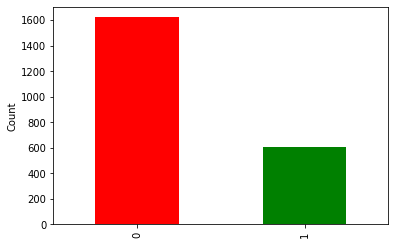

0    1623
1     604
Name: Accept_One, dtype: int64


In [83]:
### Imbalanced Classification Targets ###
my_colors = ['red', 'green']
marketing['Accept_One'].value_counts().plot(kind='bar', color=my_colors)
plt.ylabel('Count')
plt.show()
print(marketing['Accept_One'].value_counts())

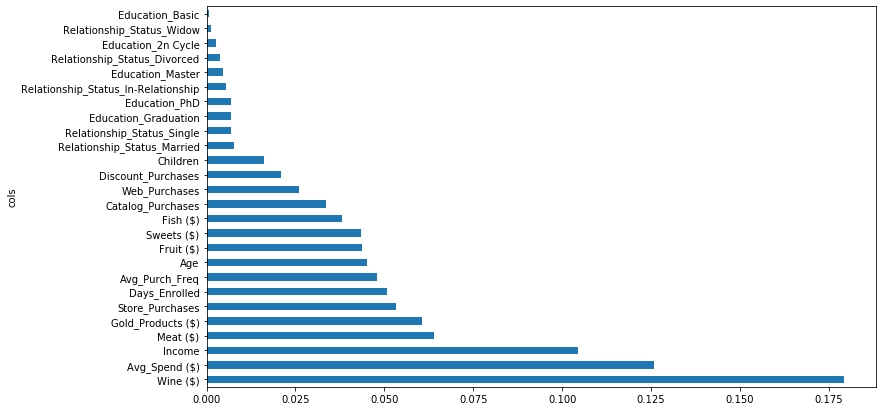


OOB Score:  0.8077844311377246

Best Params: {'max_features': 0.5, 'min_samples_leaf': 2, 'n_estimators': 100}

Testing Accuracy: 0.8043087971274686
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       399
           1       0.74      0.48      0.58       158

    accuracy                           0.80       557
   macro avg       0.78      0.71      0.73       557
weighted avg       0.80      0.80      0.79       557

[[372  27]
 [ 82  76]]

ROC_AUC:  0.7066717426477586


In [84]:
### RandomForest ###

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

ml = ml.drop('Total Spent ($)', axis=1)
categorical = categorical.drop('Total Spent ($)', axis=1)
X = ml.values
y = marketing['Accept_One'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=5,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


**Summary of XBG Hyperparameter tuning steps I took for each XGboost model**

In [85]:
### Gradient Boosting ####
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=.125, n_estimators=90, subsample=.8, max_features='sqrt', max_depth=5, min_samples_split=.85,
                    min_samples_leaf=25,random_state=27)
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

[12:00:26] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Testing Accuracy: 0.800718132854578
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       399
           1       0.70      0.51      0.59       158

    accuracy                           0.80       557
   macro avg       0.77      0.71      0.73       557
weighted avg       0.79      0.80      0.79       557

[[365  34]
 [ 77  81]]

ROC_AUC:  0.7137225976333238


**--------------------Undersampling----------------------------**

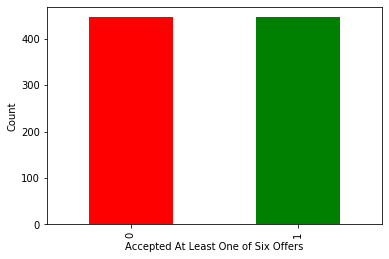

Acceptance Value Counts
1    446
0    446
dtype: int64


In [86]:
### Undersampling ###
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
acceptance = pd.Series(y_resampled)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()
print('Acceptance Value Counts')
print(acceptance.value_counts())


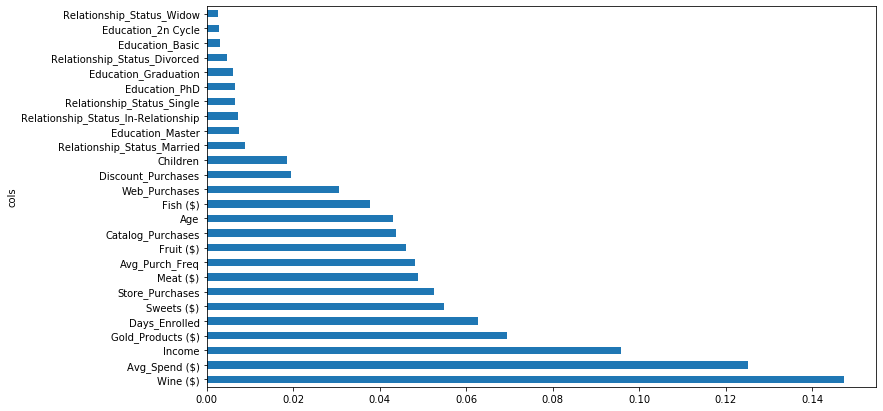


OOB Score:  0.7544843049327354

Best Params: {'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}

Testing Accuracy: 0.7522441651705566
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       399
           1       0.55      0.75      0.63       158

    accuracy                           0.75       557
   macro avg       0.71      0.75      0.72       557
weighted avg       0.79      0.75      0.76       557

[[301  98]
 [ 40 118]]

ROC_AUC:  0.7506107039751276


In [87]:
### Random Forest Classifier Using Undersampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_resampled, y_resampled)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

In [88]:
### Gradient Boost Classifier Using Undersampling ###

xgb = XGBClassifier(learning_rate=.025, n_estimators=160, subsample=.75, max_features='sqrt', max_depth=12, min_samples_split=.82,
                    min_samples_leaf=50,random_state=27)
xgb.fit(X_resampled, y_resampled)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


[12:01:23] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Testing Accuracy: 0.755834829443447
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       399
           1       0.55      0.75      0.63       158

    accuracy                           0.76       557
   macro avg       0.72      0.75      0.73       557
weighted avg       0.79      0.76      0.76       557

[[303  96]
 [ 40 118]]

ROC_AUC:  0.7531169696392881


**-------------------Oversampling---------------------------------**

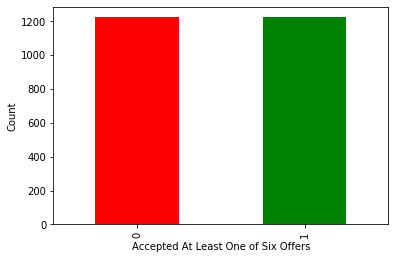

1    1224
0    1224
dtype: int64


In [89]:
### Oversampling ###
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1, random_state=47)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())

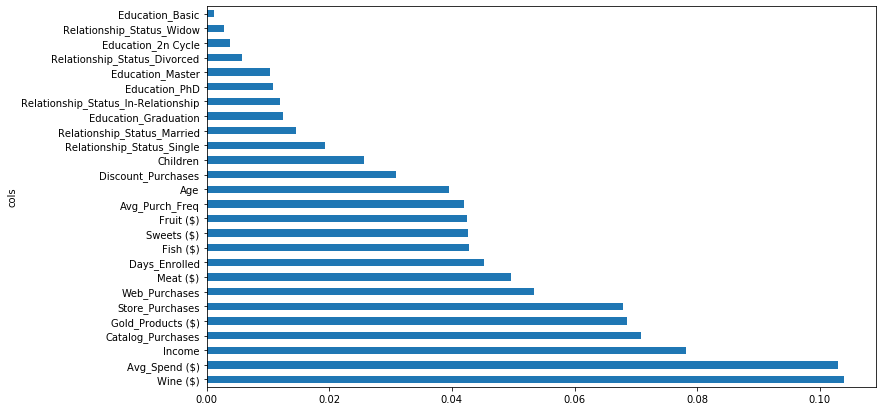


OOB Score:  0.8876633986928104

Best Params: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 400}

Testing Accuracy: 0.8061041292639138
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       399
           1       0.67      0.61      0.64       158

    accuracy                           0.81       557
   macro avg       0.76      0.75      0.75       557
weighted avg       0.80      0.81      0.80       557

[[352  47]
 [ 61  97]]

ROC_AUC:  0.7480647822086863


In [90]:
### Random Forest Classifier Using Oversampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=6,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_sm, y_sm)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)


plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

[12:04:20] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




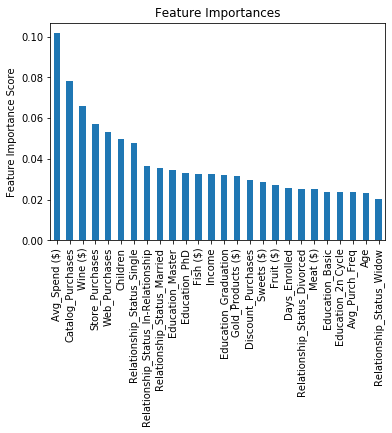


Testing Accuracy: 0.8043087971274686
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       399
           1       0.67      0.61      0.64       158

    accuracy                           0.80       557
   macro avg       0.76      0.74      0.75       557
weighted avg       0.80      0.80      0.80       557

[[352  47]
 [ 62  96]]

ROC_AUC:  0.744900225246661


In [91]:
### Gradient Boost Classifier Using Oversampling ###
from xgboost import XGBClassifier


xgb = XGBClassifier(learning_rate = .0025, n_estimators = 1800, subsample=.8, max_features='sqrt', max_depth=18, min_samples_split=.224,
                    min_samples_leaf=40,random_state=27)
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
feat_imp = pd.Series(xgb.feature_importances_, categorical.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


**After classifying a customer as Accepted (1), classify their offer acceptance rate (indicates customers that are most likely to accept the offer each time it is sent out)**

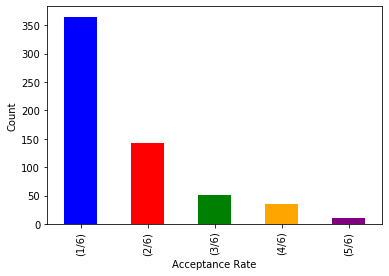

  Accept_Rate  # Customers
0       (1/6)          365
1       (2/6)          142
2       (3/6)           51
3       (4/6)           36
4       (5/6)           10


In [38]:
### Sclicing to only included customers who accepted at least one offer ###
marketing = pd.read_csv('Cust_Records.csv')
marketing_accept = marketing.loc[marketing['Accept_One'] == 1].reset_index(drop=True)

### Distribution of Those Who Accepted At Least One Offer ###
my_colors = ['blue', 'red', 'green', 'orange', 'purple']
new = marketing_accept.groupby('Accept_Rate')['Accept_One'].count().reset_index()
new.columns = ['Accept_Rate', '# Customers']
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance Rate')
plt.ylabel('Count')
plt.show()
print(new)


**Will Split Acceptance Rate into THREE groups "Least Likely"(1 - Accept Only 1/6), "More Likely"(2 - Accept 2/6 or 3/6), "Most Likely" (3 - Accept 4/6 or 5/6). 

In [39]:
### Numerically Encoding the three likelihood groups ^ with Accept_Rate ###

for idx, row in marketing_accept.iterrows():
    if row['Accept_Rate'] == '(1/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 1
    elif row['Accept_Rate'] == '(2/6)' or row['Accept_Rate'] == '(3/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 2
    elif row['Accept_Rate'] == '(4/6)' or row['Accept_Rate'] == '(5/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 3
    
marketing_ml_accept = marketing_accept.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml_accept[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)
### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml_accept, columns=['Education', 'Relationship_Status'], drop_first=False)
### Appending the categorical features to end on unskewed DF ###
ml_accept = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']], how='right')

Imbalanced Multiclass Problem


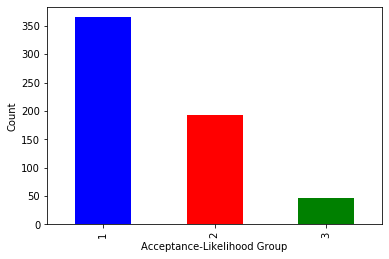

 Acceptance-Likelihood Group  # Customers
                           1          365
                           2          193
                           3           46

Oversampling


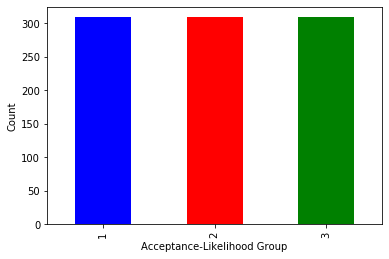

1    309
2    309
3    309
dtype: int64


In [40]:
### Classifier for Accept_Rate - Gradient Boosting ###

X = ml_accept.values
y = marketing_accept['Accept_Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

new = marketing_accept.groupby('Accept_Rate')['Accept_One'].count().reset_index()
new.columns = ['Acceptance-Likelihood Group', '# Customers']
print('Imbalanced Multiclass Problem')
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance-Likelihood Group')
plt.ylabel('Count')
plt.show()
print(new.to_string(index=False))

### SMOTE - Oversampling ###
from imblearn.over_sampling import SMOTE
print('\nOversampling')
sm = SMOTE(n_jobs=-1, random_state=47)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().sort_index().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance-Likelihood Group')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts().sort_index())

In [41]:
### Gradient Boosting - Predicting Acceptance Likelihood Group (no hyperparameter tuning) ###

xgb = XGBClassifier()
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))


Testing Accuracy: 0.6813186813186813
              precision    recall  f1-score   support

           1       0.80      0.77      0.78        56
           2       0.50      0.58      0.54        26
           3       0.57      0.44      0.50         9

    accuracy                           0.68        91
   macro avg       0.62      0.60      0.61        91
weighted avg       0.69      0.68      0.68        91

[[43 12  1]
 [ 9 15  2]
 [ 2  3  4]]


In [60]:
### Gradient Boosting - Predicting Acceptance Likelihood Group (hyperparameter tuning) ###


xgb = XGBClassifier(learning_rate=.005, n_estimators=1250, subsample=.75, max_features='sqrt', max_depth=22, min_samples_split=.524, num_class=3, objective='multi:softmax',
                    min_samples_leaf=25, random_state=27)
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

[11:45:03] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Testing Accuracy: 0.7032967032967034
              precision    recall  f1-score   support

           1       0.81      0.84      0.82        56
           2       0.57      0.50      0.53        26
           3       0.40      0.44      0.42         9

    accuracy                           0.70        91
   macro avg       0.59      0.59      0.59        91
weighted avg       0.70      0.70      0.70        91

[[47  7  2]
 [ 9 13  4]
 [ 2  3  4]]
